# Sales Forecasting System

# Dataset

## Description and Usage

This dataset contains transaction records of used car sales. It captures comprehensive details about each vehicle's specifications, physical condition, sale location, and final price, offering a broad view of the secondary car market.

**Volume:** Approximately 558,837 rows (cars) and 16 columns (features).

**Target Variable:** sellingprice (The actual price the car was sold for).

### Key Feature Categories

Vehicle Specs: make, model, trim, year, body (SUV, Sedan, etc.), transmission, color, and interior.

### Condition & Usage:

* odometer: The mileage on the car.
* condition: A numerical rating (1–49) assessing the car's physical state.
* Valuation & Price:
* mmr: Manheim Market Report (estimated wholesale market value).
* sellingprice: The final transaction price.
* Transaction Details: vin, seller, saledate, and state.

### Analytics Possibilities

* Region-wise Analysis: Compare states (e.g., CA vs. TX) to see how sales volume, prices, or inventory differ across regions.
* Time Series Forecasting: Use saledate to track sales over time and build models (Prophet/ARIMA) to predict future demand or pricing.
* Seasonality Analysis: Identify cyclical patterns—like convertibles gaining value in summer or SUVs rising in winter.

## Source

- **Kaggle (License : MIT)**

In [2]:
import pandas as pd
import numpy as np

In [5]:
dataframe = pd.read_csv("archive/car_prices.csv")
#dataframe = dataframe.drop(columns=["Unnamed: 0"])
display(dataframe.head())

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


# EDA

In [145]:
dataframe.shape

(545616, 16)

In [146]:
dataframe["year"].unique() # vehicle years

array([2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005,
       2004, 2003, 2002, 2001, 2000, 1999, 1998, 1995, 1996, 1997, 1994,
       1992, 1993, 1991, 1990], dtype=int64)

In [147]:
dataframe.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object')

In [148]:
dataframe.dtypes

year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
mmr             float64
sellingprice    float64
saledate         object
dtype: object

In [149]:
print(dataframe.isnull().sum())

year             0
make             0
model           98
trim             0
body             0
transmission     0
vin              0
state            0
condition        0
odometer         0
color            0
interior         0
seller           0
mmr             12
sellingprice    12
saledate        12
dtype: int64


In [63]:
# Impute/drop missing? Decision to take

In [8]:
#dataframe["saledate"] = pd.to_datetime(dataframe["saledate"])
#dataframe.iloc[2896, :]
#DATE_FORMAT = '%a %b %d %Y %H:%M:%S GMT%z (%Z)' # this raises an error as well

# RUN THIS FIRST (UNCOMMENT BELOW)

#dataframe["saledate"] = dataframe["saledate"].str.replace(r' \((.*?)\)', '', regex=True)
dataframe
DATE_FORMAT = '%a %b %d %Y %H:%M:%S GMT%z'
dataframe["saledate"] = pd.to_datetime(
    dataframe["saledate"],
    format=DATE_FORMAT,
    errors='coerce'
)

print(dataframe["saledate"].head())
dataframe.dtypes


0   2014-12-16 12:30:00-08:00
1   2014-12-16 12:30:00-08:00
2   2015-01-15 04:30:00-08:00
3   2015-01-29 04:30:00-08:00
4   2014-12-18 12:30:00-08:00
Name: saledate, dtype: datetime64[ns, UTC-08:00]


year                                int64
make                               object
model                              object
trim                               object
body                               object
transmission                       object
vin                                object
state                              object
condition                         float64
odometer                          float64
color                              object
interior                           object
seller                             object
mmr                               float64
sellingprice                      float64
saledate        datetime64[ns, UTC-08:00]
dtype: object

# Feature Eng

| Feature Category | New Column Name | Description |
| :--- | :--- | :--- |
| **Date & Time** | `sale_year`, `sale_month` | Extracted from `saledate`. Useful for trends and seasonality. |
| | `sale_dayofweek` | 0=Monday, 6=Sunday. |
| | `is_weekend` | **1** if sold on Sat/Sun, **0** otherwise. |
| **Age & Usage** | `car_age` | **Corrected calculation**: `sale_year - year`. Negatives are clipped to 0. |
| | `odometer_per_year` | **Usage Intensity**: `odometer / (car_age + 1)`. Shows if a car was driven heavily. |
| **Categorical** | `make_model` | **Interaction**: Combines Brand + Model (e.g., "ford_f150"). Captures specific model values better than just brand. |
| | `is_luxury` | **Binary Flag**: **1** for luxury brands (BMW, Mercedes, Lexus, etc.), **0** for economy. |
| | `color_simple` | **Grouped**: Keeps the top 10 colors; changes rare colors (like 'purple', 'orange') to 'other'. |
| **Binning** | `odometer_level` | **Buckets**: 'low' (<30k), 'average' (30k-100k), 'high' (>100k). |
| | `condition_level` | **Buckets**: 'poor' (<20), 'fair' (20-35), 'good' (35-45), 'excellent' (>45). |

In [169]:
# Feature Engineering

# A. Date Features
# Extract various date components
dataframe['sale_year'] = dataframe['saledate'].dt.year
dataframe['sale_month'] = dataframe['saledate'].dt.month
dataframe['sale_week'] = dataframe['saledate'].dt.isocalendar().week
dataframe['sale_day'] = dataframe['saledate'].dt.day
dataframe['sale_dayofweek'] = dataframe['saledate'].dt.dayofweek  # Monday=0
dataframe['sale_quarter'] = dataframe['saledate'].dt.quarter

# B. Age Features
# Clip negative ages to 0 (fixes the "bad values" issue)
dataframe['car_age'] = (dataframe['sale_year'] - dataframe['year']).clip(lower=0)
# Usage Intensity (add 1 to age to avoid division by zero)
dataframe['odometer_per_year'] = dataframe['odometer'] / dataframe['car_age'].replace(0, 1)

# C. Categorical Engineering
# 1. Luxury Flag
luxury_brands = ['bmw', 'mercedes-benz', 'lexus', 'audi', 'infiniti', 'acura', 'cadillac', 'land rover', 'porsche', 'volvo']
dataframe['is_luxury'] =dataframe['make'].apply(lambda x: 1 if x in luxury_brands else 0)

# 2. Make_Model Interaction
dataframe['make_model'] =dataframe['make'] + '_' + dataframe['model']

# 3. Simplify Colors (Group rare ones)
top_10_colors = dataframe['color'].value_counts().nlargest(10).index
dataframe['color_simple'] = dataframe['color'].apply(lambda x: x if x in top_10_colors else 'other')

# D. Binning (Discretization)
# Bin Odometer: Low, Average, High
dataframe['odometer_level'] = pd.cut(dataframe['odometer'], bins=[-1, 30000, 100000, float('inf')], labels=['low', 'average', 'high'])

# Bin Condition: Poor, Fair, Good, Excellent
dataframe['condition_level'] = pd.cut(dataframe['condition'], bins=[-1, 20, 35, 45, 100], labels=['poor', 'fair', 'good', 'excellent'])

dataframe.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,sale_day,sale_dayofweek,sale_quarter,car_age,odometer_per_year,is_luxury,make_model,color_simple,odometer_level,condition_level
0,2015,kia,sorento,lx,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,...,16.0,1.0,4.0,0.0,16639.0,0,kia_sorento,white,low,poor
1,2015,kia,sorento,lx,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,...,16.0,1.0,4.0,0.0,9393.0,0,kia_sorento,white,low,poor
2,2014,bmw,3 series,328i sulev,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,...,15.0,3.0,1.0,1.0,1331.0,1,bmw_3 series,gray,low,good
3,2015,volvo,s60,t5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,...,29.0,3.0,1.0,0.0,14282.0,1,volvo_s60,white,low,good
4,2014,bmw,6 series gran coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,...,18.0,3.0,4.0,0.0,2641.0,1,bmw_6 series gran coupe,gray,low,good


In [153]:
dataframe['saledate'].min(), dataframe['saledate'].max()


(Timestamp('2014-01-01 09:15:00-0800', tz='UTC-08:00'),
 Timestamp('2015-03-06 07:00:00-0800', tz='UTC-08:00'))

<Axes: xlabel='saledate'>

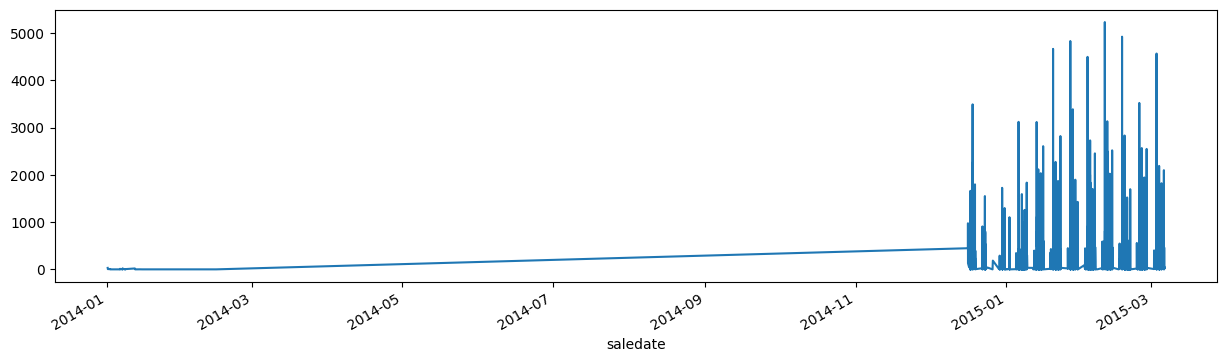

In [165]:
import matplotlib

dataframe['saledate'].value_counts().sort_index().plot(figsize=(15,4))


In [166]:
full_range = pd.date_range(dataframe['saledate'].min(), dataframe['saledate'].max(), freq='D')
missing_days = full_range.difference(dataframe['saledate'].dt.date.unique())
print("Missing days:", len(missing_days))

Missing days: 429


## Statistical Summary & Data Quality

In [167]:
# Display descriptive statistics for numerical columns
print("=" * 80)
print("DESCRIPTIVE STATISTICS")
print("=" * 80)
display(dataframe.describe())

DESCRIPTIVE STATISTICS


,year,condition,odometer,mmr,sellingprice,sale_year,sale_month,sale_week,sale_day,sale_dayofweek,sale_quarter,car_age,odometer_per_year
count,545616.000000,545616.000000,545616.000000,545604.000000,545604.000000,385610.000000,385610.000000,385610.0,385610.000000,385610.000000,385610.000000,385610.000000,385610.000000
mean,2010.141966,30.890758,67243.165288,13893.439748,13733.527511,2014.865084,3.083865,10.399735,15.667327,2.122593,1.403169,4.972734,15917.982642
std,3.887353,13.245768,52710.802036,9652.729163,9725.216424,0.341634,3.566121,13.773422,8.382793,1.033463,1.023213,3.943217,9741.528731
min,1990.000000,1.000000,1.000000,25.000000,1.000000,2014.000000,1.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.040000
25%,2008.000000,24.000000,28049.000000,7350.000000,7100.000000,2015.000000,1.000000,4.0,8.000000,1.000000,1.000000,2.000000,10158.833333
50%,2012.000000,35.000000,51121.000000,12350.000000,12250.000000,2015.000000,2.000000,7.0,17.000000,2.000000,1.000000,3.000000,13902.000000
75%,2013.000000,41.000000,97490.000000,18400.000000,18300.000000,2015.000000,2.000000,9.0,23.000000,3.000000,1.000000,8.000000,19398.821429
max,2015.000000,49.000000,999999.000000,182000.000000,230000.000000,2015.000000,12.000000,52.0,31.000000,6.000000,4.000000,25.000000,999999.000000


## Missing Values Analysis

In [119]:
# Calculate missing value percentages
missing_info = pd.DataFrame({
    'Column': dataframe.columns,
    'Missing_Count': dataframe.isnull().sum().values,
    'Missing_Percentage': (dataframe.isnull().sum().values / len(dataframe) * 100).round(2)
})

missing_info = missing_info[missing_info['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print("\nMissing Values Summary:")
display(missing_info)
print(f"\nTotal rows: {len(dataframe)}")
print(f"Rows with at least one missing value: {dataframe.isnull().any(axis=1).sum()}")


Missing Values Summary:


,Column,Missing_Count,Missing_Percentage
15,saledate,160006,29.33
16,sale_year,160006,29.33
17,sale_month,160006,29.33
18,sale_week,160006,29.33
19,sale_day,160006,29.33
20,sale_dayofweek,160006,29.33
21,sale_quarter,160006,29.33
2,model,98,0.02
13,mmr,12,0.00
14,sellingprice,12,0.00



Total rows: 545616
Rows with at least one missing value: 160070


## Categorical Columns Analysis

In [120]:
# Analyze categorical columns
categorical_cols = dataframe.select_dtypes(include=['object']).columns.tolist()
print(f"\nTotal Categorical Columns: {len(categorical_cols)}")
print("\nUnique values per categorical column:")

for col in categorical_cols:
    unique_count = dataframe[col].nunique()
    print(f"\n{col}: {unique_count} unique values")
    if unique_count <= 20:
        print(dataframe[col].value_counts())


Total Categorical Columns: 10

Unique values per categorical column:

make: 53 unique values

model: 772 unique values

trim: 1497 unique values

body: 86 unique values

transmission: 3 unique values
transmission
automatic    465575
Unknown       63189
manual        16852
Name: count, dtype: int64

vin: 537309 unique values

state: 38 unique values

color: 20 unique values
color
black        109388
white        103639
gray          81525
silver        81467
blue          49774
red           42525
—             24451
gold          10898
green         10796
beige          8905
burgundy       8744
brown          6611
orange         1986
purple         1507
off-white      1415
yellow         1232
charcoal        472
turquoise       224
pink             42
lime             15
Name: count, dtype: int64

interior: 17 unique values
interior
black        240938
gray         173443
beige         58268
tan           42798
—             16409
brown          8410
red            1312
silver        

## Numerical Columns Distribution

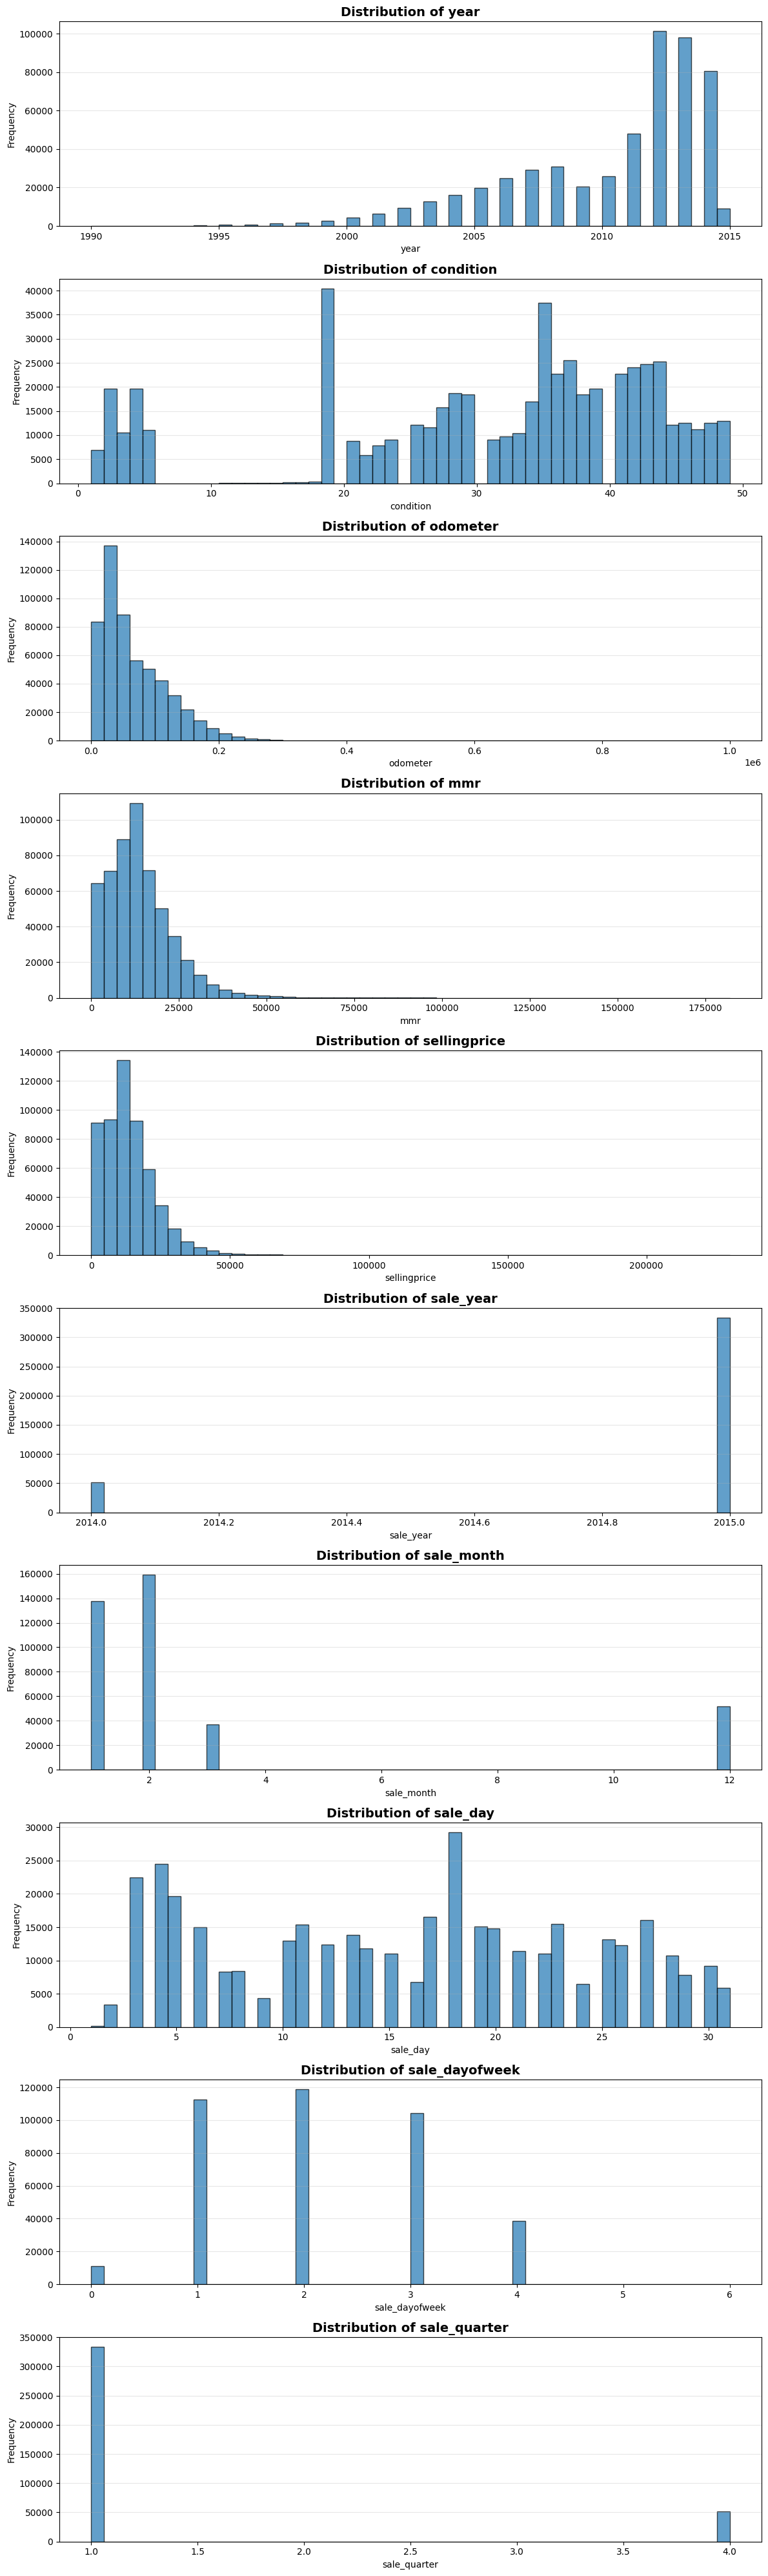

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create distribution plots for numerical columns
numerical_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(12, 4*len(numerical_cols)))

if len(numerical_cols) == 1:
    axes = [axes] # always iterable

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(dataframe[col].dropna(), bins=50, edgecolor='black', alpha=0.7) # no null data
    axes[idx].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout() # no overlap of label and title
plt.show()

## Correlation Analysis

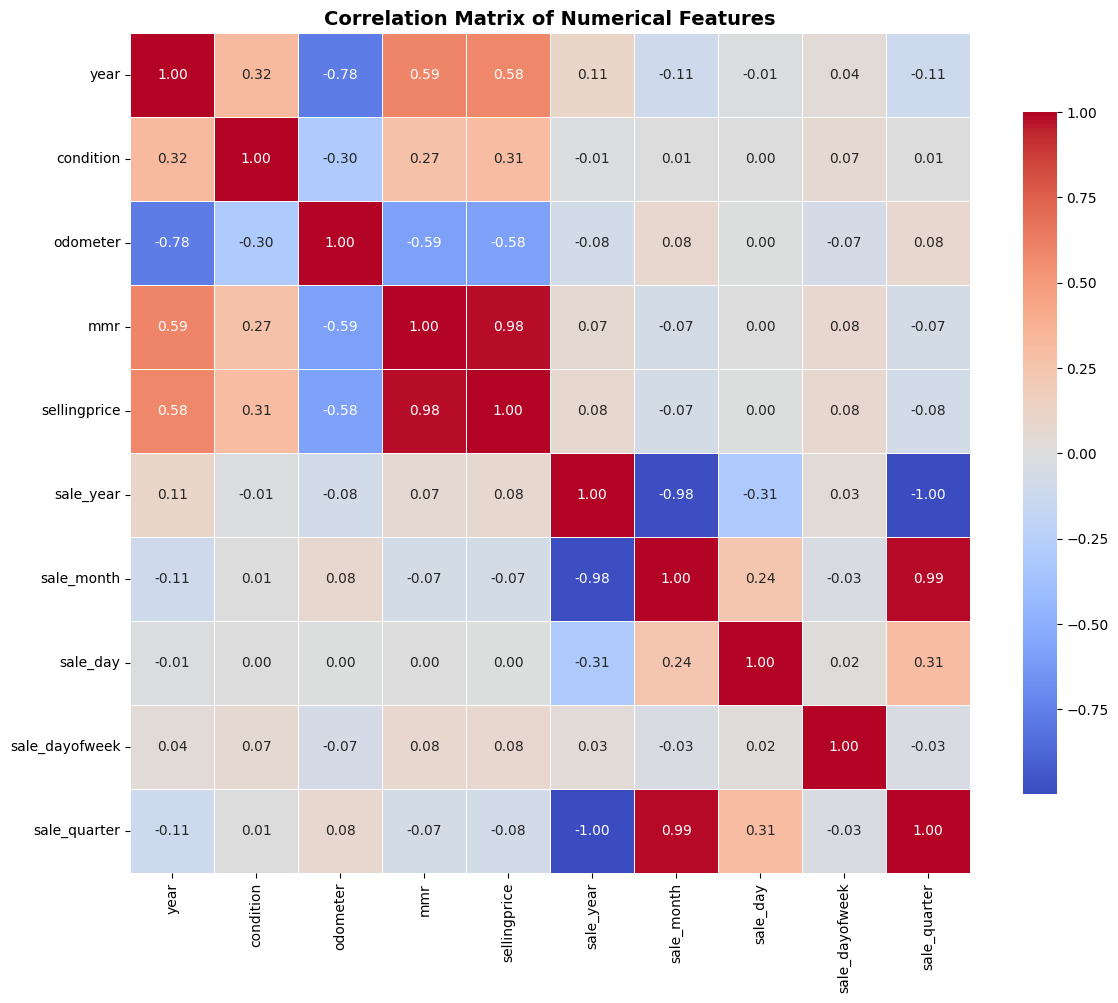


Highest Correlations with 'price' (if available):


In [123]:
# Compute correlation matrix for numerical columns
numerical_data = dataframe.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_data.corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print top correlations with price (if exists)
print("\nHighest Correlations with 'price' (if available):")
if 'price' in correlation_matrix.columns:
    correlations = correlation_matrix['price'].sort_values(ascending=False)
    print(correlations)

## Time Series Analysis - Sales Volume Over Time

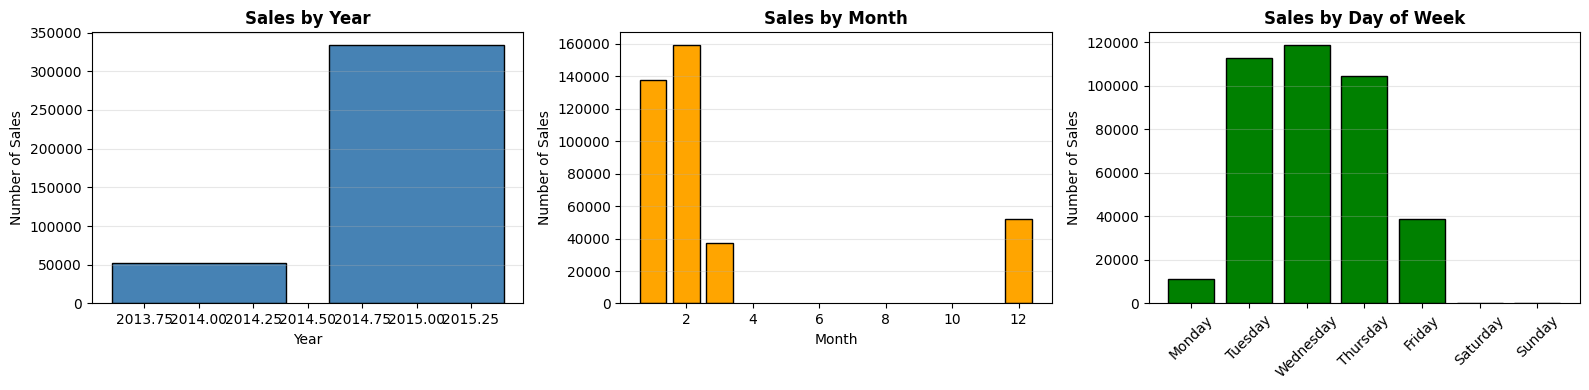

In [124]:
# Analyze sales by year and month
sales_by_year = dataframe.groupby('sale_year').size()
sales_by_month = dataframe.groupby('sale_month').size()
sales_by_dayofweek = dataframe.groupby('sale_dayofweek').size()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Sales by Year
axes[0].bar(sales_by_year.index, sales_by_year.values, color='steelblue', edgecolor='black')
axes[0].set_title('Sales by Year', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Sales')
axes[0].grid(axis='y', alpha=0.3)

# Sales by Month
axes[1].bar(sales_by_month.index, sales_by_month.values, color='orange', edgecolor='black')
axes[1].set_title('Sales by Month', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Sales')
axes[1].grid(axis='y', alpha=0.3)

# Sales by Day of Week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[2].bar(range(len(sales_by_dayofweek)), sales_by_dayofweek.values, color='green', edgecolor='black')
axes[2].set_xticks(range(len(day_names)))
axes[2].set_xticklabels(day_names, rotation=45)
axes[2].set_title('Sales by Day of Week', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Number of Sales')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Regional Analysis - Top States & Manufacturers


TOP 15 STATES BY SALES:
state
fl    81152
ca    71140
pa    53058
tx    44956
ga    33888
nj    27274
il    23094
oh    21176
nc    21160
tn    20647
mo    15732
mi    15235
nv    12370
va    11627
md    10749
Name: count, dtype: int64


TOP 15 MANUFACTURERS (Make) BY SALES:
make
ford             93554
chevrolet        60179
nissan           53946
toyota           39871
dodge            30710
honda            27203
hyundai          21816
bmw              20719
kia              18077
chrysler         17276
mercedes-benz    17141
jeep             15372
infiniti         15305
volkswagen       12555
lexus            11861
Name: count, dtype: int64


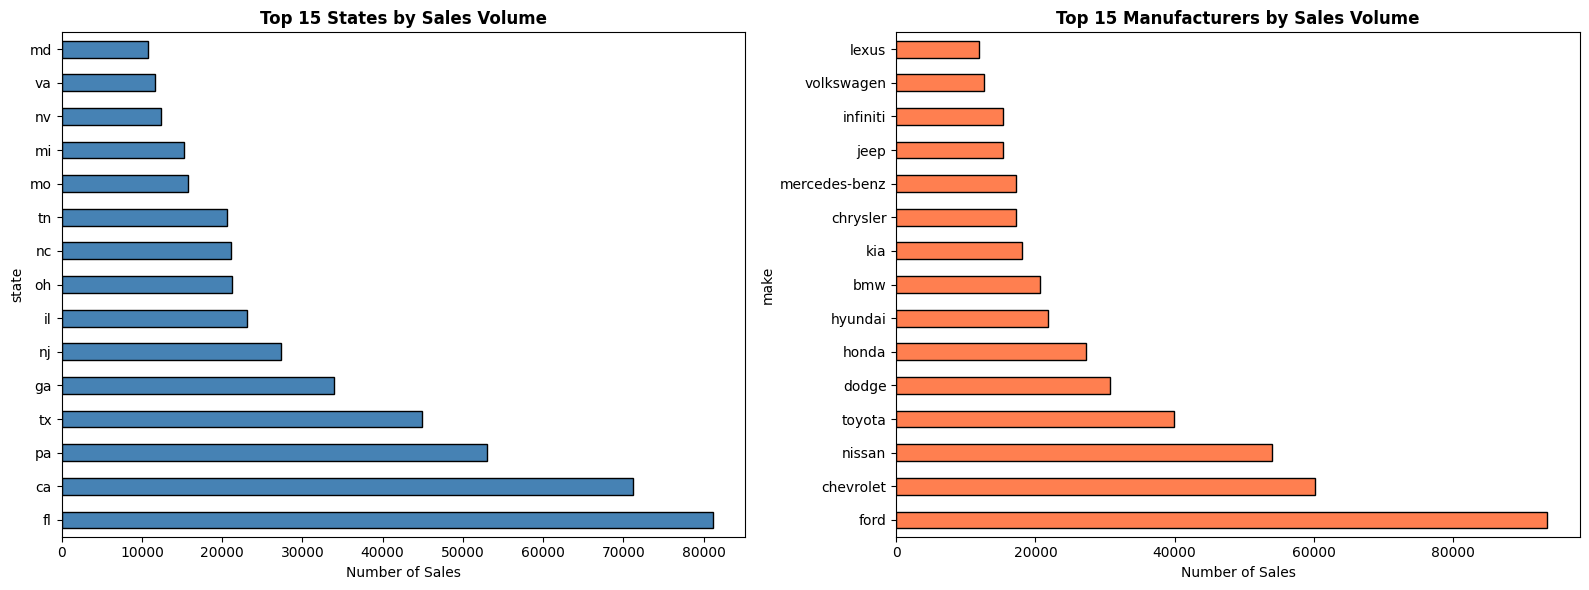

In [125]:
# Identify key states and makes for forecasting
print("\nTOP 15 STATES BY SALES:")
top_states = dataframe['state'].value_counts().head(15)
print(top_states)

print("\n\nTOP 15 MANUFACTURERS (Make) BY SALES:")
top_makes = dataframe['make'].value_counts().head(15)
print(top_makes)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top States
top_states.plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Top 15 States by Sales Volume', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Sales')

# Top Makes
top_makes.plot(kind='barh', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('Top 15 Manufacturers by Sales Volume', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Sales')

plt.tight_layout()
plt.show()

## Key Insights & Data Preparation Notes"

In [9]:
# Summary statistics for forecasting
print("\n" + "="*80)
print("EDA SUMMARY FOR SALES FORECASTING")
print("="*80)

print(f"\nDATASET OVERVIEW:")
print(f"  • Total Records: {len(dataframe):,}")
print(f"  • Date Range: {dataframe['saledate'].min()} to {dataframe['saledate'].max()}")
if pd.notna(dataframe['saledate'].min()) and pd.notna(dataframe['saledate'].max()):
    print(f"  • Total Days: {(dataframe['saledate'].max() - dataframe['saledate'].min()).days}")

print(f"\nGEOGRAPHIC DISTRIBUTION:")
print(f"  • Unique States: {dataframe['state'].nunique()}")
print(f"  • Top State: {dataframe['state'].value_counts().index[0]} ({dataframe['state'].value_counts().values[0]} sales)")

print(f"\nMARKET COMPOSITION:")
print(f"  • Unique Manufacturers: {dataframe['make'].nunique()}")
print(f"  • Unique Models: {dataframe['model'].nunique()}")
print(f"  • Top Make: {dataframe['make'].value_counts().index[0]} ({dataframe['make'].value_counts().values[0]} sales)")

print(f"\nPRICING INSIGHTS:")
if 'sellingprice' in dataframe.columns:
    print(f"  • Average Price: ${dataframe['sellingprice'].mean():,.2f}")
    print(f"  • Median Price: ${dataframe['sellingprice'].median():,.2f}")
    print(f"  • Price Range: ${dataframe['sellingprice'].min():,.2f} - ${dataframe['sellingprice'].max():,.2f}")

print(f"\nSEASONALITY INDICATORS:")
if 'sale_month' in dataframe.columns and dataframe['sale_month'].notna().any():
    print(f"  • Average Sales per Month: {dataframe.groupby('sale_month').size().mean():.0f}")
    if dataframe['sale_month'].value_counts().shape[0] > 0:
        print(f"  • Peak Month: {dataframe['sale_month'].value_counts().index[0]} with {dataframe['sale_month'].value_counts().values[0]} sales")
if 'sale_dayofweek' in dataframe.columns and dataframe['sale_dayofweek'].notna().any():
    print(f"  • Avg Sales per Day of Week: {dataframe.groupby('sale_dayofweek').size().mean():.0f}")

print("\n" + "="*80)


EDA SUMMARY FOR SALES FORECASTING

DATASET OVERVIEW:
  • Total Records: 558,837
  • Date Range: 2014-01-01 09:15:00-08:00 to 2015-03-06 07:00:00-08:00
  • Total Days: 428

GEOGRAPHIC DISTRIBUTION:
  • Unique States: 64
  • Top State: fl (82945 sales)

MARKET COMPOSITION:
  • Unique Manufacturers: 96
  • Unique Models: 973
  • Top Make: Ford (93554 sales)

PRICING INSIGHTS:
  • Average Price: $13,611.36
  • Median Price: $12,100.00
  • Price Range: $1.00 - $230,000.00

SEASONALITY INDICATORS:



## Data Pre-processing

**Data Cleaning**
1. Filter Corrupted Rows (Keep only rows where the 'state' abbreviation is exactly 2 characters long)
2. Drop Duplicates
3. Consistency (Standardize Strings) (Convert make and model to lowercase to merge "Ford" and "ford")

In [10]:
df = pd.read_csv("archive/car_prices.csv")
# 1. Filter Corrupted Rows
# Keep only rows where the 'state' abbreviation is exactly 2 characters long
df = df[df['state'].astype(str).str.len() == 2]

# 2. Drop Duplicates
df = df.drop_duplicates()

# 3. Consistency (Standardize Strings)
# Convert make and model to lowercase to merge "Ford" and "ford"
df['make'] = df['make'].astype(str).str.lower()
df['model'] = df['model'].astype(str).str.lower()
df['trim'] = df['trim'].astype(str).str.lower()

print(f"Shape after cleaning: {df.shape}")

Shape after cleaning: (558811, 16)


**Missing Values**
1. Transmission: Fill missing with "Unknown"
2. Make/Model/Body: Drop rows where these specific columns are missing
3. Color, Interior: Fill missing with Mode (Low missingness ~0.1%)
4. Condition/Odometer: Fill missing with Median (We calculate median first to avoid leakage (though less of an issue in simple cleaning)



In [11]:

df['transmission'] = df['transmission'].fillna('Unknown')


df = df.dropna(subset=['make', 'model', 'body'])


if df['color'].isnull().sum() > 0:
    df['color'] = df['color'].fillna(df['color'].mode()[0])
if df['interior'].isnull().sum() > 0:
    df['interior'] = df['interior'].fillna(df['interior'].mode()[0])
    
condition_median = df['condition'].median()
odometer_median = df['odometer'].median()

df['condition'] = df['condition'].fillna(condition_median)
df['odometer'] = df['odometer'].fillna(odometer_median)

print(df.isnull().sum())
df.to_csv('archive/processed.csv')

year             0
make             0
model            0
trim             0
body             0
transmission     0
vin              0
state            0
condition        0
odometer         0
color            0
interior         0
seller           0
mmr             12
sellingprice    12
saledate        12
dtype: int64


# Future Goals

## Forecasting
### Multi-level Forecasting

- Sales per state
- Sales per make

### External Regressors

- Fuel Price Index
- Interest Rates Data

## Dashboard

### Interactive Time-Series Dashboard
- Using Streamlit

- Forecasted VS Actual Sales
- Region-wise heatmap of sales
- Make-wise bar charts
- Manufacturer -> View Model Sales -> View Prediction

### Future Price Dynamics

- **Predict**: future price trends for each make/model
e.g., "Used Toyota Corolla prices are expected to rise 3% in next 6 months."

### Condition-Based Forecasting

- **Forecast** sales by condition

## Extra

### State-level market classification

- Cluster states by: average selling price, average odometer, most popular makes.

Organize into:

- Budget markets
- Luxury markets
- High-volume states